In [6]:
import pandas as pd
from pathlib import Path
from prophet import Prophet
import logging
import cmdstanpy
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
import matplotlib.pyplot as plt

In [20]:
def timeseriesmodelprediction(region: str, option: str = 'total') -> pd.DataFrame:
    DF = pd.DataFrame(columns=['date', 'ons', 'offs', 'total'])
    folder = Path('OpalPatronage')
    ind = 0
    for file in folder.glob('*.txt'):
        try:
            df = pd.read_csv(file, sep='|')
            df = df[df['ti_region'] == region]
            df[['Tap_Ons', 'Tap_Offs']] = df[['Tap_Ons', 'Tap_Offs']].replace({'<50': 25, '<100': 50})
            df['tap_hour'] = df['tap_hour'].astype(int)
            df['Tap_Ons'] = df['Tap_Ons'].astype(int)
            df['Tap_Offs'] = df['Tap_Offs'].astype(int)
            date = pd.to_datetime(df['trip_origin_date'].unique()[0])
            if date >= pd.to_datetime('2022-01-01'):
                DF.loc[ind] = [date, df['Tap_Ons'].sum(), df['Tap_Offs'].sum(), df['Tap_Ons'].sum() + df['Tap_Offs'].sum()]
                ind += 1
        except Exception:
            pass
    DF.sort_values(by='date', inplace=True)
    DF.dropna(subset=['ons', 'offs', 'total'], inplace=True)
    df_total = DF[['date', option]].copy()
    df_total.rename(columns={'date': 'ds', option: 'y'}, inplace=True)
    df_total['ds'] = pd.to_datetime(df_total['ds'])

    model = Prophet()
    model.fit(df_total)

    future_dates = pd.date_range(start='2025-07-16', periods=169, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})

    forecast = model.predict(future_df)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(
    columns={
        'ds': 'Date',
        'yhat': 'Predicted value',
        'yhat_lower': 'Lower bound',
        'yhat_upper': 'Upper bound'
    }
)

In [21]:
timeseriesmodelprediction('All - NSW','total')

,Date,Predicted value,Lower bound,Upper bound
0,2025-07-16,4.079638e+06,3.577492e+06,4.607418e+06
1,2025-07-17,4.116614e+06,3.587904e+06,4.658490e+06
2,2025-07-18,3.846066e+06,3.282027e+06,4.374751e+06
3,2025-07-19,2.831671e+06,2.279163e+06,3.384883e+06
4,2025-07-20,2.363614e+06,1.800716e+06,2.927714e+06
...,...,...,...,...
164,2025-12-27,2.254799e+06,1.744980e+06,2.842721e+06
165,2025-12-28,1.741894e+06,1.228609e+06,2.288988e+06
166,2025-12-29,3.082191e+06,2.517258e+06,3.616766e+06
167,2025-12-30,3.449457e+06,2.884969e+06,3.981827e+06


In [30]:
def pre2025(region: str, option: str = 'total'):
    DF = pd.DataFrame(columns=['date', 'ons', 'offs', 'total'])
    folder = Path('OpalPatronage')
    ind = 0
    for file in folder.glob('*.txt'):
        try:
            df = pd.read_csv(file, sep='|')
            df = df[df['ti_region'] == region]
            df[['Tap_Ons', 'Tap_Offs']] = df[['Tap_Ons', 'Tap_Offs']].replace({'<50': 25, '<100': 50})
            df['tap_hour'] = df['tap_hour'].astype(int)
            df['Tap_Ons'] = df['Tap_Ons'].astype(int)
            df['Tap_Offs'] = df['Tap_Offs'].astype(int)
            date = pd.to_datetime(df['trip_origin_date'].unique()[0])
            if date >= pd.to_datetime('2025-01-01'):
                DF.loc[ind] = [date, df['Tap_Ons'].sum(), df['Tap_Offs'].sum(), df['Tap_Ons'].sum() + df['Tap_Offs'].sum()]
                ind += 1
        except Exception:
            pass
    DF.sort_values(by='date', inplace=True)
    DF.dropna(subset=['ons', 'offs', 'total'], inplace=True)
    df_total = DF[['date', option]].copy()
    return df_total

In [37]:
def timeserieschart(region: str, option: str = 'total'):
    forecast = timeseriesmodelprediction(region, option)
    forecast = forecast.rename(columns={'Date': 'date', 'Predicted value': option})
    forecast = forecast[['date', option]]
    pre2025_df = pre2025(region, option)
    pre2025_df.rename(columns={'date': 'date', option: option}, inplace=True)
    combined_df = pd.concat([pre2025_df, forecast], ignore_index=True)
    plt.figure(figsize=(10, 5))
    plt.plot(combined_df['date'], combined_df[option], label='Predicted', color='blue')
    plt.title(f'Timeseries Forecast for {region}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Value')
    plt.legend()
    plt.grid()
    plt.show()

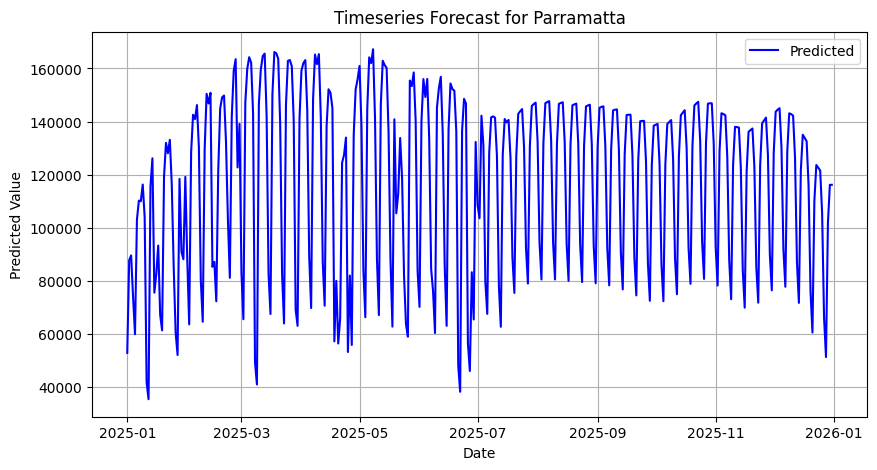

In [38]:
timeserieschart('Parramatta', 'total')